In [1]:
import xarray as xr
from pathlib import Path
from winter_year import WinterYear

winter_year = WinterYear(2023, 2024)
time_series_folder = '../output_folder/cms_workshop'
area_stats_stats_name = f'WY_{winter_year.from_year}_{winter_year.to_year}_SuomiNPP_meteofrance_nasa_sce_cross_comparison.nc'


area_stats_path= Path(f"{time_series_folder}").joinpath(area_stats_stats_name)
area_stats = xr.open_dataset(area_stats_path)

In [2]:
from typing import List
from matplotlib.axes import Axes
import pandas as pd
import xarray as xr


def classes_bar_distribution(
    year_stats_data_array: xr.DataArray, classes_to_plot: List[str] | str = "all", ax: Axes | None = None
) -> None:
    year_data_frame = year_stats_data_array.to_pandas()
    if classes_to_plot == "all":
        classes_to_plot = year_data_frame.index

    year_data_frame = year_data_frame.transpose()
    year_data_frame.index = year_data_frame.index.strftime("%B")
    year_data_frame[classes_to_plot].plot.bar(ax=ax)

def plot_stacked(data1: pd.Series, data2: pd.Series, ax: Axes, label1: str='data1', label2: str='data2', bar_width: float=0.35, color1='tab:blue', color2='tab:orange'):

    # Bar width and x positions
    x = range(len(data1))

    # Plot stacked bar (sum of Column1 and Column2)
    ax.bar(x, data1, width=bar_width, label=label1, color=color1)
    ax.bar(x, data2, width=bar_width, bottom=data1, label=label2, color=color2)
    ax.set_xticks([i + bar_width / 2 for i in x])

def plot_separate_bar(data: pd.Series, ax: Axes, label:str='data', bar_width:float=0.35, color='tab:green'):
    x = range(len(data))
    # Plot separate bar (Column3)
    ax.bar([i + bar_width for i in x],data, width=bar_width, label=label,color=color)
    ax.set_xticks([i + bar_width / 2 for i in x])


Text(0.5, 1.0, 'Snow mapping for Winter Year 2023/2024')

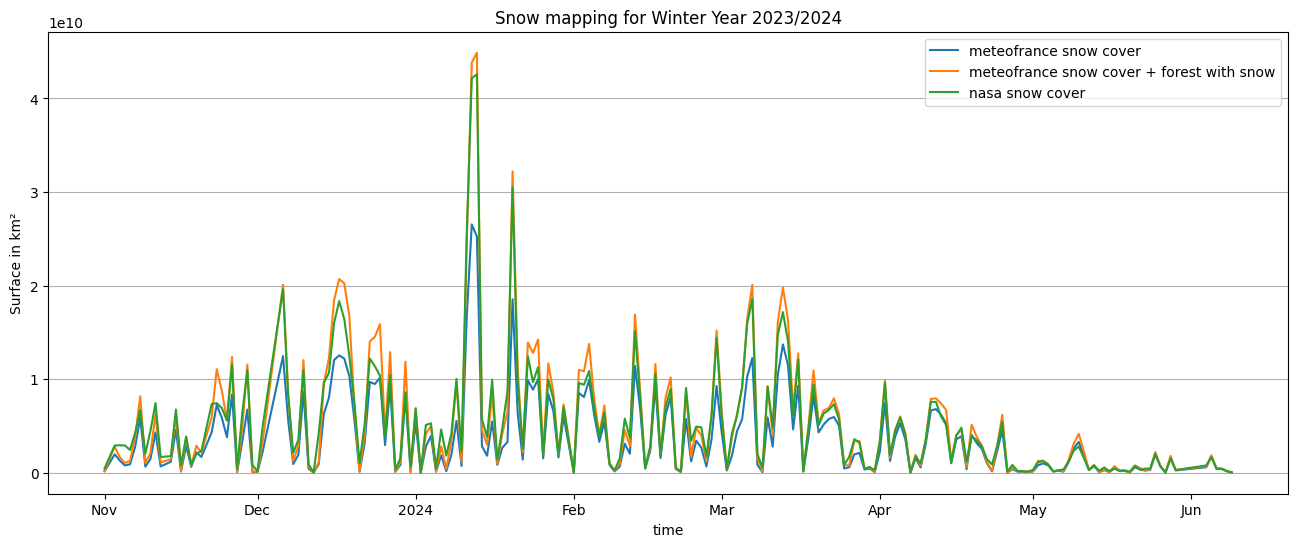

In [3]:
import matplotlib.pyplot as plt
fig,ax  = plt.subplots(figsize=(16,6))
area_stats_short = area_stats.isel(time=slice(30,240))
area_stats_short['meteofrance'].sel(class_name='snow_cover').plot(ax=ax, label='meteofrance snow cover')
mf_total_snow = area_stats_short['meteofrance'].sel(class_name='snow_cover') + area_stats_short['meteofrance'].sel(class_name='forest_with_snow') 
mf_total_snow.plot(ax=ax, label='meteofrance snow cover + forest with snow')
area_stats_short['nasa'].sel(class_name='snow_cover').plot(ax=ax, label='nasa snow cover')
ax.legend()
ax.grid(True,axis='y')
ax.set_ylabel('Surface in km²')
ax.set_title(f'Snow mapping for {str(winter_year)}')

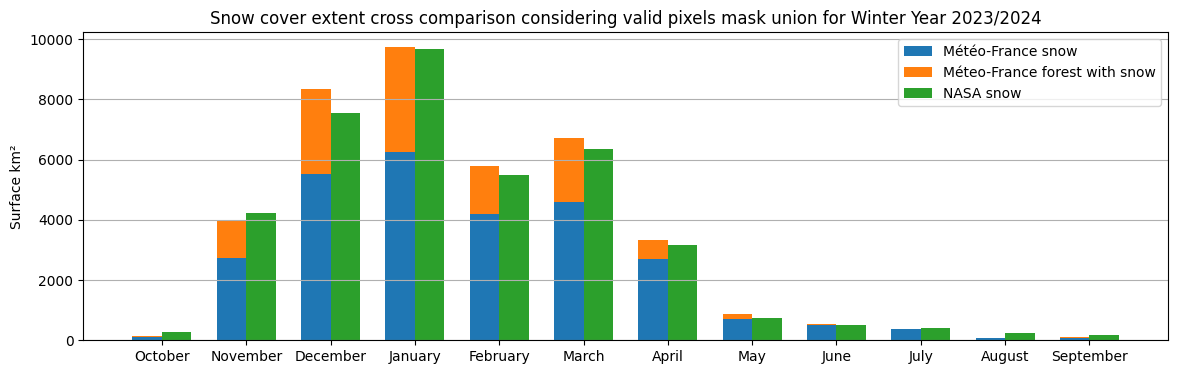

In [4]:
import matplotlib.pyplot as plt
from datetime import datetime
def daily_average(data_array: xr.DataArray):
    time_coord = data_array.coords['time'].values
    month_datetime = datetime(int(str(time_coord[0])[:4]), int(str(time_coord[0])[5:7]), int(str(time_coord[0])[8:10]))
    return xr.DataArray([data_array.sum().values / len(time_coord)], coords={'time': [month_datetime]})

fig,ax  = plt.subplots(figsize=(14,4))
mf_snow = area_stats['meteofrance'].sel(class_name='snow_cover').groupby('time.month').map(daily_average).sortby('time').to_pandas()
mf_forest_with_snow = area_stats['meteofrance'].sel(class_name='forest_with_snow').groupby('time.month').map(daily_average).sortby('time').to_pandas()
nasa_snow = area_stats['nasa'].sel(class_name='snow_cover').groupby('time.month').map(daily_average).sortby('time').to_pandas()


plot_stacked(mf_snow*1e-6, mf_forest_with_snow*1e-6, ax=ax,label1="Météo-France snow", label2="Méteo-France forest with snow")
plot_separate_bar(nasa_snow*1e-6, ax=ax, label="NASA snow")
ax.set_xticklabels(mf_snow.index.strftime("%B"))
ax.set_ylabel('Surface km²')
ax.grid(True,axis='y')
ax.legend()

plt.title(f'Snow cover extent cross comparison considering valid pixels mask union for {str(winter_year)}')
plt.show()